In [3]:
import torch, torchvision, requests, json, warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore")


In [6]:
import requests
import json

def fetch_imagenet_labels():
    '''Fetch and parse the list of ImageNet labels.'''
    response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
    response.raise_for_status()  # Raise an exception for HTTP errors
    desc_dict = json.loads(response.text)
    desc_list = [desc_dict[str(i)][1] for i in range(1000)]

# URL where the ImageNet labels are stored
label_map = fetch_imagenet_labels()

# Testing our functions
class_index = 200  # example class index (number between 0 and 999)

class_index = 834  # example class index (number between 0 and 999)


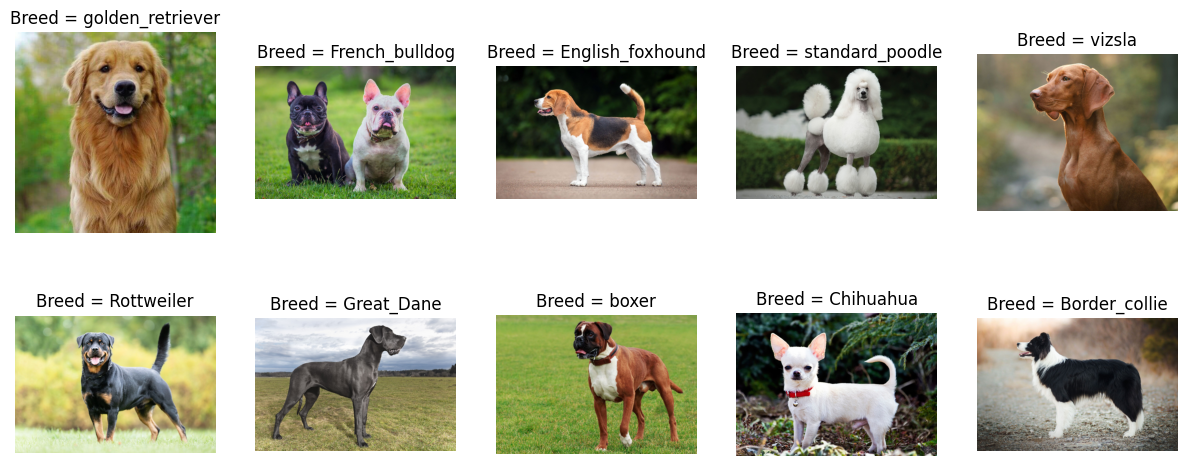

In [17]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def fetch_imagenet_labels():
    url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        desc_dict = json.loads(response.text)
        # Return a dict instead of list for safety
        return {int(k): v[1] for k, v in desc_dict.items()}
    except Exception as e:
        print("⚠️ Failed to load labels:", e)
        return {}


# Example list of dog image URLs
dog_image_urls = {
    "golden_retriever": "https://www.vidavetcare.com/wp-content/uploads/sites/234/2022/04/golden-retriever-dog-breed-info.jpeg",
    "French_bulldog": "https://cdn.britannica.com/45/233845-050-6B6A7F3E/Two-French-bulldogs.jpg",
    "English_foxhound": "https://cdn.britannica.com/16/234216-050-C66F8665/beagle-hound-dog.jpg",
    "standard_poodle": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2023/02/09141023/Diana-the-Poodle.jpg",
    "vizsla": "https://cdn.britannica.com/07/256407-050-0CC1C421/Hungarian-Vizsla-dog.jpg",
    "Rottweiler": "https://cdn.britannica.com/69/234469-050-B883797B/Rottweiler-dog.jpg",
    "Great_Dane": "https://t3.gstatic.com/licensed-image?q=tbn:ANd9GcRcAG6kQ7sRfqAFpa0cTDReX1H2XvoAyl0wXspv8l3eghN4akRvQoPbdtIU9_s7BrLM",
    "boxer": "https://cdn.britannica.com/46/233846-050-8D30A43B/Boxer-dog.jpg",
    "Chihuahua": "https://encrypted-tbn2.gstatic.com/licensed-image?q=tbn:ANd9GcR3frqA6qXxPHb5gk9vrZQgcHHA78oUVPshn_5s4k1SQ4hUnq7ScWTNp2YOgJYhUuDeLP5hRI_KJXujwiU",
    "Border_collie": "https://cdn.britannica.com/25/234625-050-6070814C/Border-Collie-dog.jpg"
}

plt.figure(figsize=(15, 6))
for i, (breed, url) in enumerate(dog_image_urls.items()):
    img = fetch_image_from_url(url)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis(False)
    plt.title(f"Breed = {breed}")
plt.show()

In [18]:
import torchvision.transforms as transforms

# TRANSFORMATIONs
preprocess = transforms.Compose([
    transforms.Resize(256),           # Resize the short side of the image to 256
    transforms.CenterCrop(224),       # Crop a center patch of the image of size 224x224
    transforms.ToTensor(),            # Convert the image to tensor format
    transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model = models.resnet50(weights="IMAGENET1K_V1")
model.eval()
print("Loaded pretrained ResNet50")


Loaded pretrained ResNet50


In [19]:
# --- Extract embeddings ---
def get_embedding(img):
    x = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        feats = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(x))))))))
        feats = torch.flatten(feats, 1)
    return feats.squeeze().numpy()


embeddings = []
names = list(dog_image_urls.keys())

for breed, url in dog_image_urls.items():
    emb = get_embedding(fetch_image_from_url(url))
    embeddings.append(emb)

embeddings = np.vstack(embeddings)
print("Collected embeddings:", embeddings.shape)

Collected embeddings: (10, 2048)


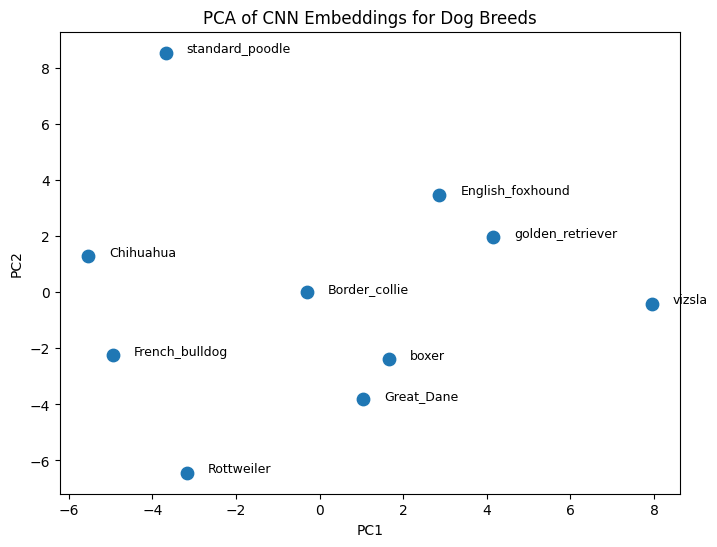

In [20]:
# --- PCA Visualization ---
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], s=80)
for i, name in enumerate(names):
    plt.text(reduced[i, 0] + 0.5, reduced[i, 1], name, fontsize=9)
plt.title("PCA of CNN Embeddings for Dog Breeds")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


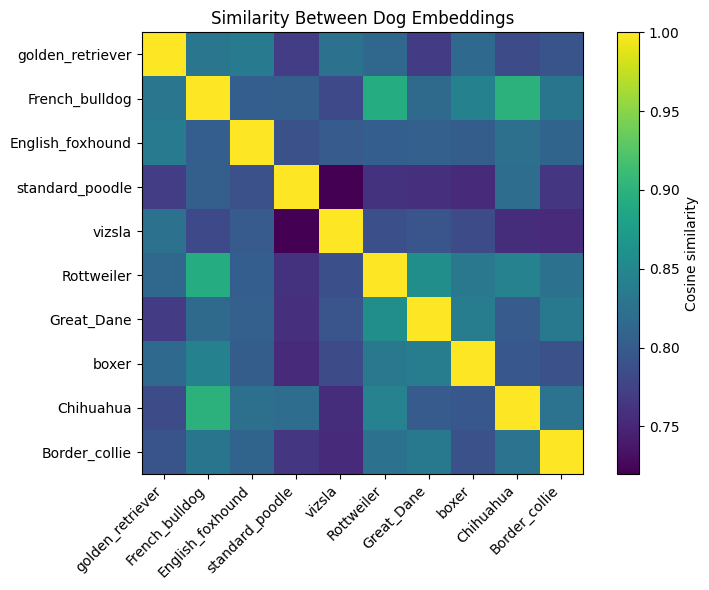

In [21]:
# --- Cosine Similarity Heatmap ---
sim = cosine_similarity(embeddings)
plt.figure(figsize=(8, 6))
plt.imshow(sim, cmap="viridis")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.yticks(range(len(names)), names)
plt.colorbar(label="Cosine similarity")
plt.title("Similarity Between Dog Embeddings")
plt.tight_layout()
plt.show()

In [24]:
# --- Saliency Map (simple gradient-based) ---
def compute_saliency(img):
    x = preprocess(img).unsqueeze(0).requires_grad_(True)
    output = model(x)
    class_idx = output.argmax().item()
    output[0, class_idx].backward()
    saliency, _ = torch.max(x.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().numpy()
    return saliency, class_idx

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, (breed, url) in enumerate(list(dog_image_urls.items())[:6]):
    img = fetch_image_from_url(url)
    sal, idx = compute_saliency(img)
    axes[i // 3, i % 3].imshow(np.array(img))
    axes[i // 3, i % 3].imshow(sal, cmap='hot', alpha=0.5)
    axes[i // 3, i % 3].axis("off")
    axes[i // 3, i % 3].set_title(f"{breed}\n{label_map[idx]}")
plt.suptitle("Saliency Maps — Model Focus Regions")
plt.tight_layout()
plt.show()